# Exercise: Pyomo.DoE

In this notebook, you will use Pyomo.DoE to compute the A- and D-optimal experiments from the TCLab. In our [previous notebook](../notebooks/doe_optimize.ipynb), we used the sine test as a starting point. In this notebook, we will use the step test as the starting point.

Recall, we can computing the next best experiment assuming we already completed one prior experiment. Thus it is important to confirm our optimal experiment design does not change if we change the prior experiment of optimization initial point.

In [1]:
import sys

# If running on Google Colab, install Pyomo and Ipopt via IDAES
on_colab = "google.colab" in sys.modules
if on_colab:
    !wget "https://raw.githubusercontent.com/dowlinglab/pyomo-doe/main/notebooks/tclab_pyomo.py"
else:
    import os

    if "exercise_solutions" in os.getcwd():
        # Add the "notebooks" folder to the path
        # This is needed for running the solutions from a separate folder
        # You only need this if you run locally
        sys.path.append('../notebooks')

# import TCLab model, simulation, and data analysis functions
from tclab_pyomo import (
    TC_Lab_data,
    TC_Lab_experiment,
    extract_results,
    extract_plot_results,
    results_summary,
)

# set default number of states in the TCLab model
number_tclab_states = 2

## Load and explore experimental data (step test)

We will load the step test experimental data, similar to our previous notebooks.

In [2]:
import pandas as pd

if on_colab:
    file = "https://raw.githubusercontent.com/dowlinglab/pyomo-doe/main/data/tclab_step_test.csv"
else:
    file = '../data/tclab_step_test.csv'
df = pd.read_csv(file)
df.head()

,Time,T1,T2,Q1,Q2
0,0.00,22.84,22.84,50.0,0.0
1,1.00,22.84,22.84,50.0,0.0
2,2.01,23.16,22.84,50.0,0.0
3,3.02,22.84,22.84,50.0,0.0
4,4.01,22.84,22.84,50.0,0.0


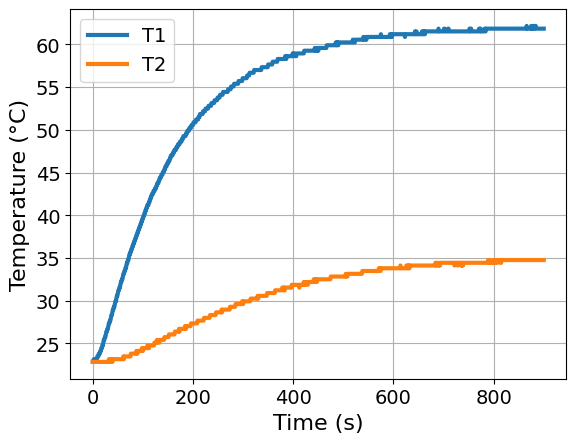

In [3]:
ax = df.plot(x='Time', y=['T1', 'T2'], xlabel='Time (s)', ylabel='Temperature (°C)')
ax.grid(True)

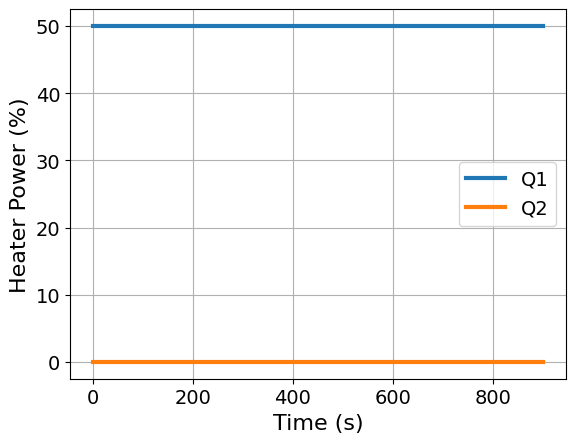

In [4]:
ax = df.plot(x='Time', y=['Q1', 'Q2'], xlabel='Time (s)', ylabel='Heater Power (%)')
ax.grid(True)

In [5]:
# Here, we will induce a step size of 10 seconds, as to not give too many 
# degrees of freedom for experimental design.
skip = 10

# Create the data object considering the new control points every 6 seconds
tc_data = TC_Lab_data(
    name="Sine Wave Test for Heater 1",
    time=df['Time'].values[::skip],
    T1=df['T1'].values[::skip],
    u1=df['Q1'].values[::skip],
    P1=200,
    TS1_data=None,
    T2=df['T2'].values[::skip],
    u2=df['Q2'].values[::skip],
    P2=200,
    TS2_data=None,
    Tamb=df['T1'].values[0],
)

## Analyze FIM with Pyomo.DoE at initial point (step test)

To get started, compute and analyze the FIM of the step test experiment.

In [6]:
# Load Pyomo.DoE class
from pyomo.contrib.doe import DesignOfExperiments

from pyomo.environ import SolverFactory

# Copied from previous notebook
theta_values = {
    'Ua': 0.0417051733576387,
    'Ub': 0.009440714239773074,
    'inv_CpH': 0.1659093525658045,
    'inv_CpS': 5.8357556063605465,
}

In [7]:
# Create experiment object for design of experiments
doe_experiment = TC_Lab_experiment(data=tc_data, theta_initial=theta_values, number_of_states=number_tclab_states)

# Create the design of experiments object using our experiment instance from above
TC_Lab_DoE = DesignOfExperiments(experiment=doe_experiment, 
                                 step=1e-2,
                                 scale_constant_value=1,
                                 scale_nominal_param_value=True, 
                                 tee=True,)

FIM = TC_Lab_DoE.compute_FIM(method='sequential')

In [8]:
# Call our custom function to summarize the results
# and compute the eigendecomposition of the FIM

results_summary(FIM)

======Results Summary======
Four design criteria log10() value:
A-optimality: 5.479278059341219
D-optimality: 8.809234454721581
E-optimality: -3.1126039391788907
Modified E-optimality: 8.570445782387669

FIM:
 [[280055.18540639  -3320.41889892 -42508.35322699  -4661.44955393]
 [ -3320.41889892    510.68043306   2729.38521901    584.8450854 ]
 [-42508.35322699   2729.38521901  20251.11718816   3322.1354697 ]
 [ -4661.44955393    584.8450854    3322.1354697     676.59046558]]

eigenvalues:
 [2.86973532e+05 1.43167335e+04 2.03307130e+02 7.71606826e-04]

eigenvectors:
 [[-9.87239625e-01  1.58273951e-01 -1.75293670e-02  1.33926737e-06]
 [ 1.29823029e-02  1.58928598e-01  7.03772484e-01 -6.92298672e-01]
 [ 1.57695528e-01  9.56659449e-01 -2.43536246e-01 -2.49983328e-02]
 [ 1.79304963e-02  1.85724948e-01  6.67148491e-01  7.21177948e-01]]


**Discussion:** How does this FIM compare to the sine test experiment we [previously analyzed](../notebooks/doe_exploratory_analysis.ipynb)?

## Optimize the next experiment (A-optimality)

Now we are ready to compute the A-optimal next best experiment. Why are we starting with A-optimality? It runs faster so it is better for debugging syntax.

In [9]:
# Create experiment object for design of experiments
doe_experiment = TC_Lab_experiment(data=tc_data, theta_initial=theta_values, number_of_states=number_tclab_states)

# Create the design of experiments object using our experiment instance from above
TC_Lab_DoE_A = DesignOfExperiments(experiment=doe_experiment, 
                                 step=1e-2,
                                 scale_constant_value=1,
                                 scale_nominal_param_value=True,
                                 objective_option="trace",  # Now we specify a type of objective, A-opt = "trace"
                                 prior_FIM=FIM,  # We use the prior information from the same existing experiment as in the D-optimal case!
                                 tee=True,)

TC_Lab_DoE_A.run_doe()

Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

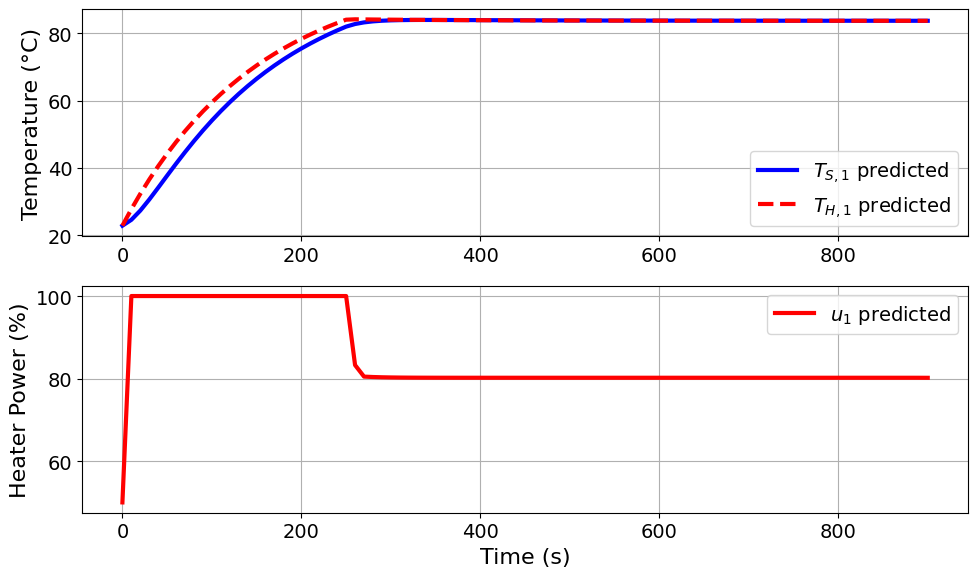

Model parameters:
Ua = 0.0421 Watts/degC
Ub = 0.0094 Watts/degC
CpH = 6.0274 Joules/degC
CpS = 0.1714 Joules/degC
 


In [10]:
# Extract and plot the results using our custom function
### BEGIN SOLUTION
aopt_pyomo_doe_results = extract_plot_results(None, TC_Lab_DoE_A.model.scenario_blocks[0])
### END SOLUTION

In [11]:
# Compute the FIM at the optimal solution
### BEGIN SOLUTION
results_summary(TC_Lab_DoE_A.results['FIM'])
### END SOLUTION

======Results Summary======
Four design criteria log10() value:
A-optimality: 6.086176677979348
D-optimality: 12.10216308145059
E-optimality: -1.8430490851995411
Modified E-optimality: 7.903999360724161

FIM:
 [[1128333.9541418809, -10344.660945130825, -152904.22848832433, -15046.559242758245], [-10344.660945130825, 2401.6027739254746, 11862.047413143466, 2711.232065796269], [-152904.22848832433, 11862.047413143466, 85659.76582339974, 14284.600287465535], [-15046.559242758245, 2711.232065796269, 14284.600287465535, 3090.281642352252]]

eigenvalues:
 [1.15066864e+06 6.76851576e+04 1.13179676e+03 1.43532720e-02]

eigenvectors:
 [[-9.89644319e-01  1.42450825e-01 -1.76602664e-02  9.29188738e-06]
 [ 1.04215507e-02  1.59402422e-01  7.01400722e-01 -6.94636082e-01]
 [ 1.42398295e-01  9.59088274e-01 -2.43539221e-01 -2.36866202e-02]
 [ 1.47729345e-02  1.85602567e-01  6.69637059e-01  7.18971249e-01]]


**Discussion:** How do these compare to our [previous A-optimal results](../notebooks/doe_optimize.ipynb) considering the sine test as the prior experiment?

## Optimize the next experiment (D-optimality)

Finally, we are ready to solve the D-optimality problem. This may take 2 minutes to run.

In [12]:
# Create experiment object for design of experiments
doe_experiment = TC_Lab_experiment(data=tc_data, theta_initial=theta_values, number_of_states=number_tclab_states)

# Create the design of experiments object using our experiment instance from above
TC_Lab_DoE_D = DesignOfExperiments(experiment=doe_experiment, 
                                 step=1e-2,
                                 scale_constant_value=1,
                                 scale_nominal_param_value=True,
                                 objective_option="determinant",  # Now we specify a type of objective, D-opt = "determinant"
                                 prior_FIM=FIM,  # We use the prior information from the existing experiment!
                                 tee=True,)

TC_Lab_DoE_D.run_doe()

Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

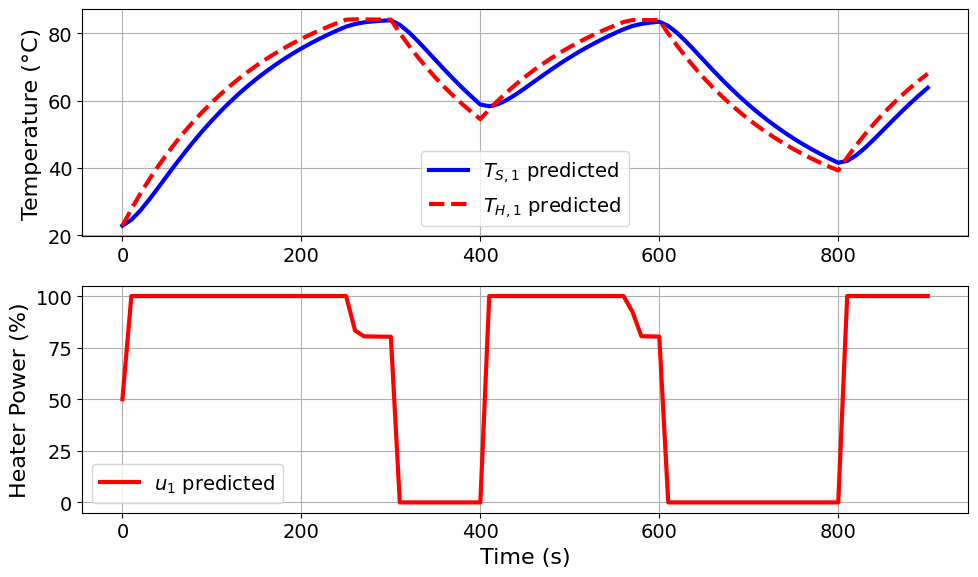

Model parameters:
Ua = 0.0421 Watts/degC
Ub = 0.0094 Watts/degC
CpH = 6.0274 Joules/degC
CpS = 0.1714 Joules/degC
 


In [13]:
# Extract and plot the results using our custom function
### BEGIN SOLUTION
dopt_pyomo_doe_results = extract_plot_results(None, TC_Lab_DoE_D.model.scenario_blocks[0])
### END SOLUTION

In [14]:
# Compute the FIM at the optimal solution
### BEGIN SOLUTION
results_summary(TC_Lab_DoE_D.results['FIM'])
### END SOLUTION

======Results Summary======
Four design criteria log10() value:
A-optimality: 5.967636028118886
D-optimality: 12.62603956232522
E-optimality: -1.8550827141000377
Modified E-optimality: 7.772789117677075

FIM:
 [[818563.0801634969, -620.1786056149823, -79956.24482342416, -3266.450673590944], [-620.1786056149823, 4866.710384232659, 15971.220200977912, 5229.79120056382], [-79956.24482342416, 15971.220200977912, 99087.96962372029, 18696.801379926546], [-3266.450673590944, 5229.79120056382, 18696.801379926546, 5670.408112132706]]

eigenvalues:
 [8.27382639e+05 9.70342163e+04 3.77129903e+03 1.39610244e-02]

eigenvectors:
 [[-9.93977609e-01  1.07151272e-01 -2.29590047e-02  4.07808937e-05]
 [ 2.91390791e-03  1.76638285e-01  6.96995197e-01 -6.94973468e-01]
 [ 1.09354088e-01  9.57308108e-01 -2.66548727e-01 -2.35509312e-02]
 [ 6.45796596e-03  2.02184836e-01  6.65298697e-01  7.18649588e-01]]


**Discussion:** How do these results compare to [our previous analysis](../notebooks/doe_exercise.ipynb)?